In [1]:
import numpy as np
import pandas as pd
from math import ceil
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, Subset
from sklearn.metrics import roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import time
import sys

from libraries import RNN_get_torch_data as torch_data

data_path = "data"

In [2]:
def feature_sampler(input, colsample, generator):
    '''
    set to zeros the sampled time series, the ones with null values are forced to be included
    Inputs
    ---
    input : torch.Tensor (batch_size, seq_len, n_features)
    colsample : scalar value in (0,1), it is the ratio of kept features
    generator : torch.Generator
    return: tensor (batch_size, seq_len, n_features)
    '''
    flags = torch.logical_not(torch.isnan(input).any(dim=1))
    n_features = input.shape[2]
    n_to_keep = ceil(n_features * colsample)
    probs = nn.functional.normalize(flags.float(), p=1, dim=1)
    cols_to_keep = torch.multinomial(probs, num_samples=n_to_keep, replacement=False, generator=generator)
    # index creation
    ind_to_keep = torch.zeros_like(input, dtype=torch.bool)
    ind_to_keep[np.arange(stop=input.shape[0])[:, np.newaxis, np.newaxis], \
                np.arange(stop=input.shape[1])[np.newaxis, :, np.newaxis], \
                cols_to_keep[:, None, :]] = True
    # masked input creation
    output = torch.where(ind_to_keep, input, torch.zeros_like(input))
    return output

In [3]:
class dense(nn.Module):
    '''
    input: tensor of size (batch_size, input_size)
    output: tensor of size (batch_size, ouput_size)
    '''
    def __init__(self, input_size, output_size, non_linearity):
        super(dense, self).__init__()
        
        # dense connection
        self.dc = nn.Linear(in_features=input_size, out_features=output_size)

        # non linearity
        if non_linearity is None:
            self.act_fn == (lambda x: x)
        if non_linearity == 'tanh':
            self.act_fn = nn.Tanh()
        elif non_linearity == 'RELU':
            self.act_fn = nn.ReLU()
        elif non_linearity == 'sigmoid':
            self.act_fn = nn.Sigmoid()
        else:
            raise ValueError('non_linearity function is not available, choose between "tanh", "RELU", "sigmoid"')
        
    def forward(self, x):
        out = self.dc(x)
        return self.act_fn(out)

In [4]:
class Model(nn.Module):
    def __init__(self, colsample, dense1_size, dense2_size, dense3_size, dense4_size, dense5_size,
        GRU_size, features, seed):
        super(Model, self).__init__()

        # initialize generator
        self.generator = torch.Generator().manual_seed(seed)

        # first features sampling step
        self.feat_sampling = lambda input: feature_sampler(input, colsample, self.generator)

        # 1st dense layer
        self.dense1 = dense(input_size=len(features), output_size=dense1_size, non_linearity='tanh')

        # GRU layer
        self.GRU = nn.GRU(input_size=dense1_size, hidden_size=GRU_size, num_layers=1,\
                bias=True, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(.5)

        # 2nd dense layer
        self.dense2 = dense(input_size=GRU_size, output_size=dense2_size, non_linearity='RELU')

        #3rd dense layer
        self.dense3 = dense(input_size=dense2_size, output_size=dense3_size, non_linearity='RELU')

        # 4th dense layer
        self.dense4 = dense(input_size=dense3_size, output_size=dense4_size, non_linearity='RELU')

        # 5th dense layer
        self.dense5 = dense(input_size=dense4_size, output_size=dense5_size, non_linearity='RELU')

        # fully connected layer
        self.fc = nn.Linear(in_features=dense5_size, out_features=1)

        # descriptive
        self.hidden_size = GRU_size
        self.features = features
        self.seed = seed

        # params
        self.colsample = colsample
    
    def forward(self, x):
        if self.training:
            # feature sampling step
            out = self.feat_sampling(input=x)
        else:
            out = torch.nan_to_num(x)

        # 1st dense layers step
        out = self.dense1(out)
        out = self.dropout(out)
        # GRU step
        out_t, _ = self.GRU(input=out)
        out = out_t.select(1, -1) # select the last hidden state
        out = self.dropout(out)
        # further dense layer steps
        out = self.dense2(out)
        out = self.dropout(out)
        out = self.dense3(out)
        out = self.dropout(out)
        out = self.dense4(out)
        out = self.dropout(out)
        out = self.dense5(out)
        out = self.dropout(out)
        # fc step
        out = torch.sigmoid(self.fc(out))

        return out

In [5]:
train_data = torch_data.get_train_data(data_path=data_path, n_perturbed_replicas=2, seed=12497)

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [45]:
def validate(device, model, metric, batch):
    model.eval()
    with torch.no_grad():
        X, y = batch[:]
        X = X.float().to(device=device)
        pred = model(X).flatten().detach().numpy()
    return metric(y_true=y, y_score=pred)

In [40]:
def batch_train(device, model, optimizer, objective_function, batch):
    X, y = batch
    X = X.float().to(device=device)
    y = y.float().to(device=device)
    optimizer.zero_grad() # Clears existing gradients from previous batch
    pred = model(X).flatten()
    loss = objective_function(pred, y)
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly

In [30]:
class TrainTrial():
    def __init__(self, batch_size, max_n_epochs, patience, min_validation_rate, train_data, seed):
        rng = np.random.Generator(np.random.PCG64(seed=seed))
        seeds = rng.integers(low=0, high=sys.maxsize, size=2).tolist()
        split_generator = torch.Generator().manual_seed(seeds[0])
        batch_generator = torch.Generator().manual_seed(seeds[1])
        n_samples = len(train_data)
        residual_batch_size = n_samples % batch_size
        if n_samples * min_validation_rate <= residual_batch_size:
            n_batches = n_samples // batch_size
            validation_batch_size = residual_batch_size
        else:
            n_batches = n_samples // batch_size - 1
            validation_batch_size = residual_batch_size + batch_size        
        assert(n_batches * batch_size + validation_batch_size == n_samples)
        
        train_validation_split = random_split(dataset=train_data,
                lengths=[len(train_data) - validation_batch_size, validation_batch_size],
                generator=split_generator)
        validation_batch = train_validation_split[1]
        train_loader = DataLoader(dataset=train_validation_split[0],
            batch_size=batch_size, shuffle=True, generator=batch_generator)

        self.n_batches = n_batches
        self.batch_size = batch_size
        self.validation_batch_size = validation_batch_size
        self.validation_batch = validation_batch
        self.train_loader = train_loader
        self.max_n_epochs = max_n_epochs
        self.patience = patience
        self.validation_scores = None
        self.best_validation_score = None
        self.trigger_times = None
        self.best_state_dict = None

    def train(self, device, model, optimizer, objective_function, validation_metric):
        self.validation_scores = []
        self.best_validation_score = - np.infty
        self.trigger_times = 0
        since = time.time()
        for epoch in range(1, self.max_n_epochs + 1):
            # training
            model.train()
            for batch in self.train_loader:
                batch_train(device=device, model=model, optimizer=optimizer, 
                    objective_function=objective_function, batch=batch)
            # validation
            current_validation_score = validate(device=device, model=model,
                metric=validation_metric, batch=self.validation_batch)
            self.validation_scores.append(current_validation_score)
            if current_validation_score > self.best_validation_score:
                self.trigger_times = 0
                self.best_validation_score = current_validation_score
                self.best_state_dict = model.state_dict()
            else:
                self.trigger_times += 1
                if self.trigger_times >= self.patience:
                    print('Early stopping.')
                    break
            # print details    
            if epoch % 10 == 0:
                print(f'Epoch {epoch}:')
                print('\ttriggers: {}'.format(self.trigger_times))
                print('\tbest score: {}'.format(self.best_validation_score))
                avg_time = round((time.time() - since) / 10, 2)
                print('\t{} seconds per epoch on average.'.format(avg_time))
                since = time.time()

        model.load_state_dict(self.best_state_dict)
        return model

In [46]:
model = Model(colsample=.5, dense1_size=400, GRU_size=200, dense2_size=200, dense3_size=150,
        dense4_size=100, dense5_size=40, features=train_data.features, seed=24338)
model = model.to(device)

In [47]:
learning_rate = .001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [48]:
trial = TrainTrial(batch_size=3000, max_n_epochs=200, patience=7,
    min_validation_rate=.05, train_data=train_data, seed=35375)

In [49]:
model = trial.train(device=device, model=model, optimizer=optimizer,
    objective_function=criterion, validation_metric=roc_auc_score)

Epoch 10:
	triggers: 0
	best score: 0.7196928009626109
	28.61 seconds per epoch on average.
Epoch 20:
	triggers: 0
	best score: 0.7384034054965337
	28.02 seconds per epoch on average.
Epoch 30:
	triggers: 0
	best score: 0.7465908553605551
	26.89 seconds per epoch on average.


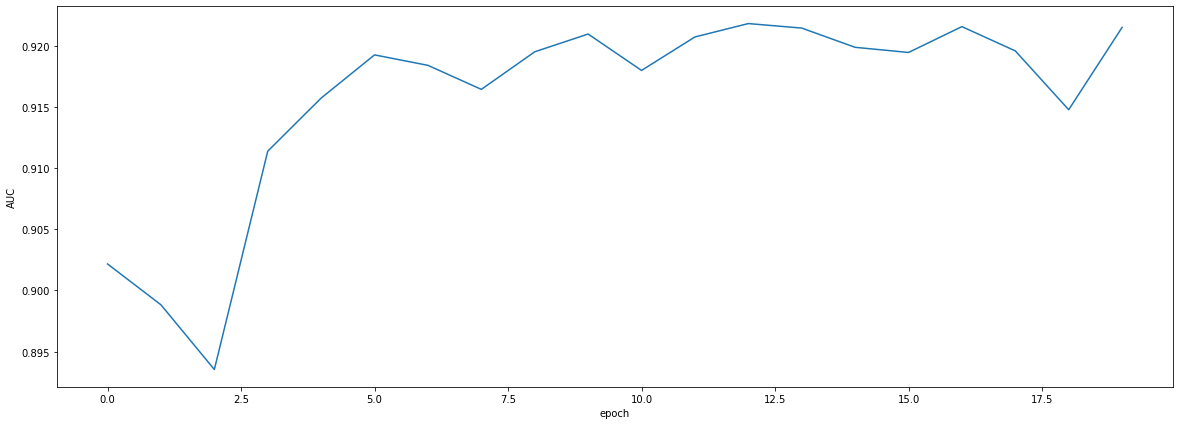

In [226]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(trial.validation_scores)
ax.set_xlabel('epoch')
ax.set_ylabel('AUC')
plt.show()

In [227]:
test_data = torch_data.get_test_data(data_path=data_path)

In [228]:
X = test_data.X.float().to(device)
y = test_data.y.float().to(device)

In [229]:
model.eval()

Model(
  (dense1): dense(
    (dc): Linear(in_features=186, out_features=800, bias=True)
    (act_fn): Tanh()
  )
  (GRU): GRU(800, 800, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (dense2): dense(
    (dc): Linear(in_features=800, out_features=500, bias=True)
    (act_fn): ReLU()
  )
  (dense3): dense(
    (dc): Linear(in_features=500, out_features=250, bias=True)
    (act_fn): ReLU()
  )
  (dense4): dense(
    (dc): Linear(in_features=250, out_features=70, bias=True)
    (act_fn): ReLU()
  )
  (fc): Linear(in_features=70, out_features=1, bias=True)
)

In [230]:
pred = model(X).detach().numpy()

In [231]:
y_true = y.detach().numpy()

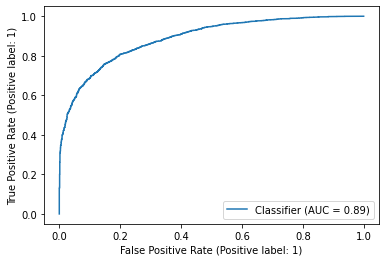

In [232]:
RocCurveDisplay.from_predictions(y_true, pred)
plt.show()